In [2]:
from collections import Counter
import os
from glob import glob
import re
import numbers

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [4]:
# Read scored obtained from Pedro
scores = pd.read_csv('../../data/P9855_learn_error_rate/p9855_scores_cv.csv')
scores = scores.drop('Unnamed: 0', axis=1)

In [5]:
scores = scores.sort_index(axis=1)
scores

,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,...,0.035,0.0351,0.0352,0.0353,0.0354,0.0355,0.0356,0.0357,0.0358,0.0359
0,-0.482336,-0.179680,-0.075062,-0.071503,-0.043545,-0.030958,-0.031745,-0.035524,-0.041393,-0.043722,...,-0.072361,-0.057337,-0.057339,-0.057342,-0.057344,-0.057347,-0.057349,-0.057352,-0.057354,-0.057357
1,-0.502847,-0.214131,-0.116350,-0.163342,-0.098098,-0.067619,-0.068998,-0.069057,-0.071326,-0.052417,...,-0.092639,-0.074192,-0.074193,-0.074195,-0.074197,-0.074198,-0.074200,-0.074202,-0.074204,-0.074205
2,-0.442904,-0.264661,-0.152362,-0.188939,-0.142383,-0.071182,-0.039471,-0.024784,-0.027834,-0.034525,...,-0.059872,-0.050567,-0.050565,-0.050562,-0.050560,-0.050558,-0.050555,-0.050553,-0.050551,-0.050548


In [6]:
# Get first 20 columns and then every 10th

# Select the first 20 columns
first_20_cols = scores.iloc[:, :20]

# Select every 10th column after the 20th column
every_10th_col_after_20th = scores.iloc[:, 20::10]

# Concatenate the selected columns into 'df2'
scores = pd.concat([first_20_cols, every_10th_col_after_20th], axis=1)

# To display the new DataFrame 'df2'
scores

,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,...,0.0261,0.0271,0.0281,0.0291,0.0301,0.0311,0.0321,0.0331,0.0341,0.0351
0,-0.482336,-0.179680,-0.075062,-0.071503,-0.043545,-0.030958,-0.031745,-0.035524,-0.041393,-0.043722,...,-0.046043,-0.051813,-0.060032,-0.077271,-0.068528,-0.068539,-0.068551,-0.068564,-0.074116,-0.057337
1,-0.502847,-0.214131,-0.116350,-0.163342,-0.098098,-0.067619,-0.068998,-0.069057,-0.071326,-0.052417,...,-0.066299,-0.069386,-0.077465,-0.094658,-0.091708,-0.091716,-0.091725,-0.091734,-0.097811,-0.074192
2,-0.442904,-0.264661,-0.152362,-0.188939,-0.142383,-0.071182,-0.039471,-0.024784,-0.027834,-0.034525,...,-0.047636,-0.051775,-0.060093,-0.077321,-0.068577,-0.068568,-0.068558,-0.068547,-0.070122,-0.050567


In [7]:
# Get list of error rates
# Use these error rates to re-run analysis of ATAC data

column_names = scores.columns.tolist()
column_names_float = [float(item) for item in column_names]
#column_names_float

In [8]:
scores

,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,...,0.0261,0.0271,0.0281,0.0291,0.0301,0.0311,0.0321,0.0331,0.0341,0.0351
0,-0.482336,-0.179680,-0.075062,-0.071503,-0.043545,-0.030958,-0.031745,-0.035524,-0.041393,-0.043722,...,-0.046043,-0.051813,-0.060032,-0.077271,-0.068528,-0.068539,-0.068551,-0.068564,-0.074116,-0.057337
1,-0.502847,-0.214131,-0.116350,-0.163342,-0.098098,-0.067619,-0.068998,-0.069057,-0.071326,-0.052417,...,-0.066299,-0.069386,-0.077465,-0.094658,-0.091708,-0.091716,-0.091725,-0.091734,-0.097811,-0.074192
2,-0.442904,-0.264661,-0.152362,-0.188939,-0.142383,-0.071182,-0.039471,-0.024784,-0.027834,-0.034525,...,-0.047636,-0.051775,-0.060093,-0.077321,-0.068577,-0.068568,-0.068558,-0.068547,-0.070122,-0.050567


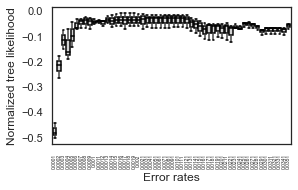

In [15]:

# Define custom colors
#box_color = 'lightgrey'
#line_color = 'black'

#with plot_style(figsize=(8, 3), ticklabelsize=10, labelsize=10):

plt.figure(figsize=(4.3, 2.8))
plt.xticks(fontsize=5)



sns.boxplot(data=scores, orient='vertical', boxprops={'edgecolor': 'black', 'facecolor': 'lightgrey'}, medianprops={'color': 'black'}, capprops={'color': 'black'})



plt.xticks(rotation=90)
plt.xlabel('Error rates')
plt.ylabel('Normalized tree likelihood')

plt.tight_layout()


plt.savefig(f'../../data/P9855_figures/learn_error_rate.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()



In [49]:
# For each error rate, compute variance, mean, median and mean over variance

pd.set_option('display.max_columns', None)

variance_row = scores.iloc[0:3, :].var(axis=0)
mean_row = scores.iloc[0:3, :].mean(axis=0)
median_row = scores.iloc[0:3, :].median(axis=0)

# Calculate median/variance
median_over_variance_row = median_row / variance_row

# Calculate mean/variance
mean_over_variance_row = mean_row / variance_row

# Create new rows and add them to the DataFrame
scores.loc['variance'] = variance_row
scores.loc['mean'] = mean_row
scores.loc['median'] = median_row
scores.loc['median/variance'] = median_over_variance_row
scores.loc['mean/variance'] = mean_over_variance_row

scores

,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014,0.0015,0.0016,0.0017,0.0018,0.0019,0.002,0.0021,0.0031,0.0041,0.0051,0.0061,0.0071,0.0081,0.0091,0.0101,0.0111,0.0121,0.0131,0.0141,0.0151,0.0161,0.0171,0.0181,0.0191,0.0201,0.0211,0.0221,0.0231,0.0241,0.0251,0.0261,0.0271,0.0281,0.0291,0.0301,0.0311,0.0321,0.0331,0.0341,0.0351
0,-0.482336,-0.179680,-0.075062,-0.071503,-0.043545,-0.030958,-0.031745,-0.035524,-0.041393,-0.043722,-0.049003,-0.039498,-0.021757,-0.017680,-0.011524,-0.010640,-0.010705,-0.010815,-0.010931,-0.011097,-0.011435,-0.016823,-0.016581,-0.016971,-0.017955,-0.015942,-0.015851,-0.015916,-0.016481,-0.017108,-0.018658,-0.027525,-0.032002,-0.038954,-0.047540,-0.051767,-0.052062,-0.050965,-0.054283,-0.049810,-0.060182,-0.054070,-0.061040,-0.047244,-0.046043,-0.051813,-0.060032,-0.077271,-0.068528,-0.068539,-0.068551,-0.068564,-0.074116,-0.057337
1,-0.502847,-0.214131,-0.116350,-0.163342,-0.098098,-0.067619,-0.068998,-0.069057,-0.071326,-0.052417,-0.041049,-0.061822,-0.038217,-0.040348,-0.036703,-0.035795,-0.035799,-0.035841,-0.035888,-0.035982,-0.031650,-0.030405,-0.030251,-0.029197,-0.028156,-0.027523,-0.027149,-0.026959,-0.027649,-0.028461,-0.031745,-0.046183,-0.051158,-0.060530,-0.071307,-0.057819,-0.059997,-0.058939,-0.066999,-0.060806,-0.069466,-0.067307,-0.073373,-0.062395,-0.066299,-0.069386,-0.077465,-0.094658,-0.091708,-0.091716,-0.091725,-0.091734,-0.097811,-0.074192
2,-0.442904,-0.264661,-0.152362,-0.188939,-0.142383,-0.071182,-0.039471,-0.024784,-0.027834,-0.034525,-0.037180,-0.038917,-0.048640,-0.062948,-0.061938,-0.061327,-0.072578,-0.061045,-0.060928,-0.060824,-0.073776,-0.065355,-0.067659,-0.067156,-0.066792,-0.066525,-0.066330,-0.066195,-0.066109,-0.066068,-0.067621,-0.082047,-0.086504,-0.098151,-0.111171,-0.114861,-0.116654,-0.104472,-0.108300,-0.114316,-0.124496,-0.068219,-0.070797,-0.049316,-0.047636,-0.051775,-0.060093,-0.077321,-0.068577,-0.068568,-0.068558,-0.068547,-0.070122,-0.050567
variance,0.000928,0.001827,0.001496,0.003813,0.002451,0.000496,0.000387,0.000533,0.000495,0.000080,0.000036,0.000171,0.000184,0.000512,0.000635,0.000642,0.000968,0.000631,0.000625,0.000618,0.001012,0.000627,0.000699,0.000685,0.000664,0.000702,0.000702,0.000698,0.000678,0.000657,0.000643,0.000768,0.000764,0.000898,0.001034,0.001212,0.001241,0.000833,0.000798,0.001191,0.001208,0.000063,0.000042,0.000067,0.000127,0.000103,0.000101,0.000100,0.000179,0.000179,0.000179,0.000179,0.000224,0.000148
mean,-0.476029,-0.219491,-0.114591,-0.141261,-0.094675,-0.056587,-0.046738,-0.043122,-0.046851,-0.043554,-0.042411,-0.046746,-0.036205,-0.040326,-0.036722,-0.035921,-0.039694,-0.035900,-0.035916,-0.035967,-0.038954,-0.037528,-0.038164,-0.037775,-0.037634,-0.036663,-0.036444,-0.036357,-0.036746,-0.037212,-0.039341,-0.051919,-0.056555,-0.065878,-0.076673,-0.074816,-0.076238,-0.071459,-0.076528,-0.074977,-0.084715,-0.063199,-0.068403,-0.052985,-0.053326,-0.057658,-0.065863,-0.083084,-0.076271,-0.076274,-0.076278,-0.076282,-0.080683,-0.060699
median,-0.482336,-0.214131,-0.116350,-0.163342,-0.098098,-0.067619,-0.039471,-0.035524,-0.041393,-0.043722,-0.041049,-0.039498,-0.038217,-0.040348,-0.036703,-0.035795,-0.035799,-0.035841,-0.035888,-0.035982,-0.031650,-0.030405,-0.030251,-0.029197,-0.028156,-0.027523,-0.027149,-0.026959,-0.027649,-0.028461,-0.031745,-0.046183,-0.051158,-0.060530,-0.071307,-0.057819,-0.059997,-0.058939,-0.066999,-0.060806,-0.069466,-0.067307,-0.070797,-0.049316,-0.047636,-0.051813,-0.060093,-0.077321,-0.068577,-0.068568,-0.068558,-0.068564,-0.074116,-0.057337
median/variance,-519.678776,-117.203793,-77.766628,-42.833390,-40.022784,-136.389578,-102.112236,-66.611527,-83.582906,-546.166947,-1129.677120,-231.590610,-208.022619,-78.759031,-57.763725,-55.729235,-36.965525,-56.819359,-57.427906,-58.205271,-31.286677,-48.501557,-43.263833,-42.634299,-42.425791,-39.188015,-38.684101,-38.611761,-40.793134,-43.337928,-49.400293,-60.147921,-66.919999,-67.441011,-68.976714,

## best median, lowest variance

In [55]:
# Select the error rates with the best median

# Get the median values
median_values = scores.loc['median']

# Sort the columns by median values in descending order
sorted_columns = median_values.sort_values(ascending=False)

# Calculate the number of columns to select (10% of total columns)
percent_to_select = 0.3
num_columns_to_select = int(len(scores.columns) * percent_to_select)

# Select the top 10% of columns
selected_columns = sorted_columns[:num_columns_to_select]

# Create a new DataFrame with only the selected columns
best_median = scores[selected_columns.index]

# To display the new DataFrame
best_median

,0.0091,0.0081,0.0071,0.0101,0.0061,0.0111,0.0051,0.0041,0.0031,0.0021,0.0121,0.0008,0.0016,0.0017,0.0018,0.0019
0,-0.015916,-0.015851,-0.015942,-0.016481,-0.017955,-0.017108,-0.016971,-0.016581,-0.016823,-0.011435,-0.018658,-0.035524,-0.010640,-0.010705,-0.010815,-0.010931
1,-0.026959,-0.027149,-0.027523,-0.027649,-0.028156,-0.028461,-0.029197,-0.030251,-0.030405,-0.031650,-0.031745,-0.069057,-0.035795,-0.035799,-0.035841,-0.035888
2,-0.066195,-0.066330,-0.066525,-0.066109,-0.066792,-0.066068,-0.067156,-0.067659,-0.065355,-0.073776,-0.067621,-0.024784,-0.061327,-0.072578,-0.061045,-0.060928
variance,0.000698,0.000702,0.000702,0.000678,0.000664,0.000657,0.000685,0.000699,0.000627,0.001012,0.000643,0.000533,0.000642,0.000968,0.000631,0.000625
mean,-0.036357,-0.036444,-0.036663,-0.036746,-0.037634,-0.037212,-0.037775,-0.038164,-0.037528,-0.038954,-0.039341,-0.043122,-0.035921,-0.039694,-0.035900,-0.035916
median,-0.026959,-0.027149,-0.027523,-0.027649,-0.028156,-0.028461,-0.029197,-0.030251,-0.030405,-0.031650,-0.031745,-0.035524,-0.035795,-0.035799,-0.035841,-0.035888
median/variance,-38.611761,-38.684101,-39.188015,-40.793134,-42.425791,-43.337928,-42.634299,-43.263833,-48.501557,-31.286677,-49.400293,-66.611527,-55.729235,-36.965525,-56.819359,-57.427906
mean/variance,-52.071300,-51.927099,-52.202644,-54.214586,-56.707747,-56.663792,-55.159776,-54.580968,-59.863599,-38.506986,-61.221317,-80.857858,-55.924706,-40.987590,-56.913923,-57.472410


In [56]:
# Select the column with the lowest variance

# Get the variance values
variance_values = best_median.loc['variance']

# Find the column with the smallest variance
column_with_smallest_variance = variance_values.idxmin()

print("The error rate is:", column_with_smallest_variance)

The error rate is: 0.0008


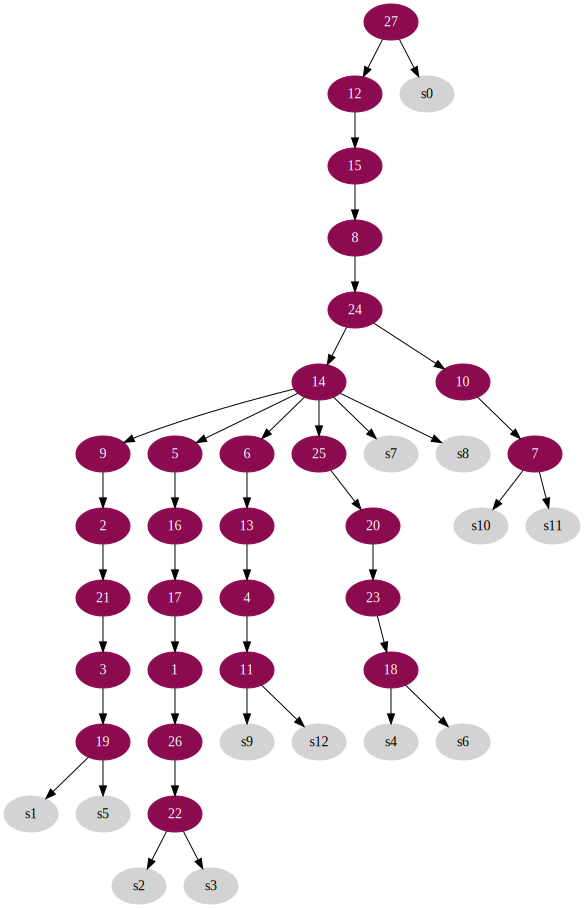

In [57]:
Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/P9855/0.0008_1_map0.gv')

In [33]:
# lowest variance, best median


# Get the variance values
#variance_values = scores.loc['variance']

# Sort the columns by variance values in ascending order
#sorted_columns = variance_values.sort_values(ascending=True)

# Calculate the number of columns to select (10% of total columns)
#percent_to_select = 0.3
#num_columns_to_select = int(len(scores.columns) * percent_to_select)

# Select the top 10% of columns
#selected_columns = sorted_columns[:num_columns_to_select]

# Create a new DataFrame with only the selected columns
#smallest_variance = scores[selected_columns.index]

# To display the new DataFrame
#smallest_variance

In [34]:
# Select the column with the highest mean

# Get the median values
#median_values = smallest_variance.loc['median']

# Find the column with the highest mean
#column_with_highest_median = median_values.idxmax()

#print("The error rate is:", column_with_highest_median)